## Comparison of pyfm2d with analytical solution for raypath and travel time in a linear gradient velocity model

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pyfm2d
import time
from tqdm import tqdm
from scipy.interpolate import RectBivariateSpline
import pandas as pd

A notebook that compares travel times and raypaths of pyfm2d with an exact analytical result.

This is for the case where velocity is a linear function of depth, $v(z) = v_o + v_g z$. 

Here there exists an analytical result for the raypath which is a circular arc and trave time.

--------

#### Utility routines for building linear gradient velocity models

In [2]:
# build test velocity model
def get_linear_velmodel(vo,vgrad,extent,nx,nz): # build velocity model with linear gradient
    dx = (extent[1]-extent[0])/nx                           # cell width
    dz = (extent[3]-extent[2])/nz                           # cell height
    xc = np.linspace(extent[0]+dx/2.,extent[1]-dx/2.,nx)    # cell centre
    zc = np.linspace(extent[2]+dz/2.,extent[3]-dz/2.,nz)    # cell centre
    X,Z = np.meshgrid(xc, zc)   # cell centre mesh
    v = vo + vgrad*Z
    return v.T

In [3]:
def pbisector(a,b,normalize=False): # calculate perpendicular bisector for pair of input co-ordinates in 2D
    if(normalize):
        g = np.array([a[1]-b[1],b[0]-a[0]])
        return g/np.linalg.norm(g)          #return normalized perpendicular bisector vector
    return np.array([a[1]-b[1],b[0]-a[0]])  #return unnormalized perpendicular bisector vector

In [4]:
def convert_kms_2_deg(src,rec,extent):
    degperkms = 180./(6371.0*np.pi)
    rec = degperkms*rec
    src = degperkms*src
    ext = [i*degperkms for i in extent] # unit box in kms converted to degrees
    return src,rec,ext

In [5]:
def tt_circular_path_anal(p0,p1,vo,vg): # travel time via analytical expression
    vs = vo + p0[1]*vg  # velocity at source
    vr = vo + p1[1]*vg  # velocity at receiver
    L = np.linalg.norm((p1-p0)) # distance between source and receiver
    time_a = np.abs(np.arccosh(1. + (vg*L)**2/(2*vs*vr))/vg) # closed form expression for travel time
    return time_a

In [6]:
def tt_circular_int(c,rad,p0,p1,n):
    p0,p1 = srcs,recs
    p0c = p0 - c
    p1c = p1 - c
    t0 = np.arctan2(p0c[1], p0c[0])
    t1 = np.arctan2(p1c[1], p1c[0])
    thetas = np.linspace(t0,t1,n)
    pos = np.zeros((n,2))
    pos[0] = srcs
    ttime = 0.
    for i in range(n-1): # loop through angles between radius 1 and radius2
        ta = thetas[i]
        tb = thetas[i+1]
        xa = xc + rad*np.cos(ta)
        za = zc + rad*np.sin(ta)
        xb = xc + rad*np.cos(tb)
        zb = zc + rad*np.sin(tb)
        pos[i+1] = np.array([xb,zb])
        vm = 0.5*(vo + za*vg + vo + zb*vg)
        dl = np.sqrt((xa-xb)**2 + (za-zb)**2)
        ttime += dl/vm
    return ttime,pos

In [7]:
def circular_raypaths(srcs,recs,vo,vg): # Calculate circular raypath
    # use analytical solution to calculate circular raypath and travel time
    thetas = []
    for isrc in range(len(srcs)):
        for irec in range(len(recs)):
            src = srcs[isrc]
            rec = recs[irec]
            g = pbisector(src,rec,normalize=True)         # normalized perpendicular bisector of source/receiver line
            xm = np.mean([src,rec],axis=0)                # mid-point of source/receiver line
            vs = vo + vg*src[1]                           # velocity at source 
            zc = src[1]-vs/vg                             # depth of centre of circular raypath
            rc = (zc-xm[1])/g[1]                          # distance to raypath centre from mid-point of source/receiver line
            xc = xm[0] + rc*g[0]                          # x co-ordinate of centre of circular raypath
            c = np.array([xc,zc])                         # centre of circular raypath
            rad =  np.linalg.norm(c-src)                  # radius of circular raypath
            rad2 =  np.linalg.norm(c-rec)                 # radius of circular raypath
            p = 1./(vg*rad)                               # ray parameter
            theta_s = np.arcsin(p*vs)                     # take off angle at source    
            if(xc < src[0]): theta_s = np.pi - theta_s  # upward/obtuse take off angle
            L = np.linalg.norm((src-rec))                 # distance between source and receiver
            thetas.append(theta_s)
            #print(isrc,irec,p,p*vs,theta_s*180/np.pi,xc)
    return thetas

In [8]:
def tt_circular_paths_anal(srcs,recs,vo,vg): # travel time via analytical expression
    ttimes = []
    for isrc in range(len(srcs)):
        for irec in range(len(recs)):
            src = srcs[isrc]
            rec = recs[irec]
            vs = vo + src[1]*vg  # velocity at source
            vr = vo + rec[1]*vg  # velocity at receiver
            L = np.linalg.norm((rec-src)) # distance between source and receiver
            time_a = np.abs(np.arccosh(1. + (vg*L)**2/(2*vs*vr))/vg) # closed form expression for travel time
            ttimes.append(time_a)
    return ttimes


----

### Specifying a velocity model

In [9]:
# velocity model parameters for linear gradient model.
vo = 3.0     # Surface velocity in km/s
vg = 0.5     # Velocity gradient in km/s per km
vg = 0.125     # Velocity gradient in km/s per km
extent = [0,30.,0.,30.] # extent on model in km
velocity_30_30 = get_linear_velmodel(vo,vg,extent,30,30)
velocity_300_300 = get_linear_velmodel(vo,vg,extent,300,300)

### Calculating raypaths

Set up source and receiver.

In [10]:
srcs = np.array([0.0,23.0])
recs = np.array([30.0,8.0])

#### Calculate two-point path and travel time with analytical solution

Here we use analytical raypath solution to calculate raypath and travel time.

In [11]:
# use analytical solution to calculate circular raypath and travel time
g = pbisector(srcs,recs,normalize=True)         # normalized perpendicular bisector of source/receiver line
xm = np.mean([srcs,recs],axis=0)                # mid-point of source/receiver line
vs = vo + vg*srcs[1]                            # velocity at source 
zc = srcs[1]-vs/vg                              # depth of centre of circular raypath
rc = (zc-xm[1])/g[1]                            # distance to raypath centre from mid-point of source/receiver line
xc = xm[0] + rc*g[0]                            # x co-ordinate of centre of circular raypath
c = np.array([xc,zc])                           # centre of circular raypath
rad =  np.linalg.norm(c-srcs)                   # radius of circular raypath
p = 1./(vg*rad)                                 # ray parameter
theta_s = np.arcsin(p*vs)                       # take off angle at source     
L = np.linalg.norm((srcs-recs))                 # distance between source and receiver

In [12]:
ttime_anal = tt_circular_path_anal(srcs,recs,vo,vg)

In [13]:
# travel time via numerical intgeration along circular path
nint = 100
ttime_int,pos = tt_circular_int(c,rad,srcs,recs,nint)

#### Calculate two-point path and travel time with wavefront tracker.

We first try Cartesian mode.

In [14]:
options = pyfm2d.WaveTrackerOptions(
    times=True,
    frechet=True,
    paths=True,
    earthradius=6371.0,
    ttfield_source=0,  # select a source index to calculate and display wavefronts.
    cartesian=True,
)

In [15]:
start_time = time.time()
result_300_300_cart = pyfm2d.calc_wavefronts(velocity_300_300, recs, srcs, extent=extent, options=options)
ctime_300_300_cart = time.time() - start_time

In [16]:
start_time = time.time()
result_30_30_cart = pyfm2d.calc_wavefronts(velocity_30_30, recs, srcs, extent=extent, options=options)
ctime_30_30_cart = time.time() - start_time
print(" Number of paths calculated = ", len(result_30_30_cart.paths))
print(" Number of travel times calculated = ", len(result_30_30_cart.ttimes))
print(" Shape of frechet matrix = ", result_30_30_cart.frechet.shape)

 Number of paths calculated =  1
 Number of travel times calculated =  1
 Shape of frechet matrix =  (1, 900)


Now we try Spherical mode.

In [17]:
options = pyfm2d.WaveTrackerOptions(
    times=True,
    frechet=True,
    paths=True,
    earthradius=6371.0,
    ttfield_source=0,  # select a source index to calculate and display wavefronts.
)

In [18]:
if(True): # here we are using a setup expressed as Cartesian but wavetracking in Spherical co-ordinates
    srcs,recs,extent = convert_kms_2_deg(srcs,recs,extent) # For Spherical model we should convert the input spatial units to degrees

In [19]:
start_time = time.time()
result_300_300_sph = pyfm2d.calc_wavefronts(velocity_300_300, recs, srcs, extent=extent, options=options)
ctime_300_300_sph = time.time() - start_time

In [20]:
start_time = time.time()
result_30_30_sph = pyfm2d.calc_wavefronts(velocity_30_30, recs, srcs, extent=extent, options=options)
ctime_30_30_sph = time.time() - start_time
print(" Number of paths calculated = ", len(result_30_30_sph.paths))
print(" Number of travel times calculated = ", len(result_30_30_sph.ttimes))
print(" Shape of frechet matrix = ", result_30_30_sph.frechet.shape)

 Number of paths calculated =  1
 Number of travel times calculated =  1
 Shape of frechet matrix =  (1, 900)


Here we use analytical raypath solution to calculate raypath and travel time.

In [21]:
lines = result_300_300_cart.paths[0:1] # fmm path
lines.append(*result_300_300_sph.paths[0:1])
lines.append(np.array([xm,xm+10*g])) # perpendicular bisector
lines.append(np.array([srcs,recs]))  # source-receiver line
lines.append(np.array(pos))  # Analytical path
clines = ['r','b','k','k','g']
wlines = [1.0,1.0,0.5,0.5,0.5]

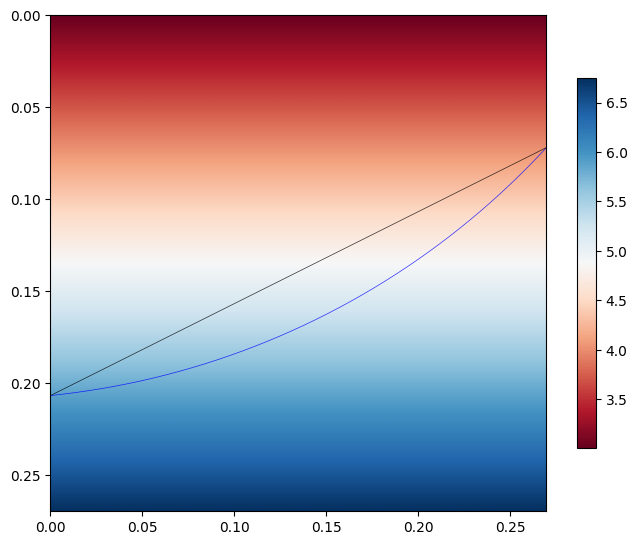

In [22]:
pyfm2d.display_model(velocity_300_300, extent=extent, figsize=(8, 8),     
              paths=lines,
              cline=clines,
              line = 0.5,
#              points=pos,
              alpha=0.8,
              aspect='equal',
              reversedepth=True)

In [23]:
# calculate statistics
vm = vo + xm[1]*vg # velocity at midpoint of source-receiver line
vp = vo + pos[int(nint/2)][1]*vg # velocity and midpoint of analytical raypath
vpert = np.abs(vp-vm)/vm
dt_t_int = np.abs(ttime_int-ttime_anal)*100/ttime_anal # fractional error in travel time w.r.t. analytical value
dt_t_fmm30_cart = np.abs(*result_30_30_cart.ttimes-ttime_anal)*100/ttime_anal # fractional error in travel time w.r.t. analytical value
dt_t_fmm300_cart =  np.abs(*result_300_300_cart.ttimes-ttime_anal)*100/ttime_anal # fractional error in travel time w.r.t. analytical value
dt_t_fmm30_sph = np.abs(*result_30_30_sph.ttimes-ttime_anal)*100/ttime_anal # fractional error in travel time w.r.t. analytical value
dt_t_fmm300_sph =  np.abs(*result_300_300_sph.ttimes-ttime_anal)*100/ttime_anal # fractional error in travel time w.r.t. analytical value
#
ttime_hom = L/vm # travel time in homogeneous medium with velocity at mid-point
res =  np.abs(ttime_hom - ttime_anal) # tt residual between bent and straight ray
dt_res_int = np.abs(ttime_int-ttime_anal)*100/res # fractional error in travel time w.r.t. analytical value
dt_res_fmm30_cart = np.abs(*result_30_30_cart.ttimes-ttime_anal)*100/res # fractional error in travel time w.r.t. analytical value
dt_res_fmm300_cart =  np.abs(*result_300_300_cart.ttimes-ttime_anal)*100/res # fractional error in travel time w.r.t. analytical value
dt_res_fmm30_sph = np.abs(*result_30_30_sph.ttimes-ttime_anal)*100/res # fractional error in travel time w.r.t. analytical value
dt_res_fmm300_sph =  np.abs(*result_300_300_sph.ttimes-ttime_anal)*100/res # fractional error in travel time w.r.t. analytical value
#

In [24]:
df = pd.DataFrame({
    "Travel time (s)": [ttime_anal, ttime_int,*result_30_30_cart.ttimes,*result_300_300_cart.ttimes,*result_30_30_sph.ttimes,
                        *result_300_300_sph.ttimes,ttime_hom],
    r"$\delta t/t_a  ~(\%)$": [  " ",dt_t_int,dt_t_fmm30_cart,dt_t_fmm300_cart,dt_t_fmm30_sph,dt_t_fmm300_sph,res*100/ttime_anal],
    r"$\delta t/r  ~(\%)$": [  " ",dt_res_int,dt_res_fmm30_cart,dt_res_fmm300_cart,dt_res_fmm30_sph,dt_res_fmm300_sph," "],
    r"$nx$": [  " "," ",30,300,30,300," "],
    r"$ny$": [  " "," ",30,300,30,300," "],
    r"$t_{cpu}$": [  " "," ",ctime_30_30_cart,ctime_300_300_cart,ctime_30_30_sph,ctime_300_300_sph," "]
})
fmmlabc = "Fast Marching (Cartesian)"
fmmlabs = "Fast Marching (Spherical)"
df.style \
  .set_caption("Linear gradient velocity model with central velocity perturbation "+r"$\delta v/v = $"+str(np.round(vpert*100,1))+"%")  \
  .format(precision=5, thousands=",", decimal=".") \
  .relabel_index(["Analytical "+r"$(t_a)$", "Num integration (n=100)",fmmlabc,fmmlabc,fmmlabs,fmmlabs,"Homogeneous"], axis=0)

,Travel time (s),$\delta t/t_a ~(\%)$,$\delta t/r ~(\%)$,$nx$,$ny$,$t_{cpu}$
Analytical $(t_a)$,6.71969,,,,,
Num integration (n=100),6.71970,0.00005,0.00435,,,
Fast Marching (Cartesian),6.72882,0.13580,12.42817,30,30,0.01143
Fast Marching (Cartesian),6.72062,0.01374,1.25738,300,300,1.38547
Fast Marching (Spherical),6.72719,0.11153,10.20713,30,30,0.01261
Fast Marching (Spherical),6.72034,0.00959,0.87746,300,300,1.45716
Homogeneous,6.79312,1.09267,,,,


### Multiple sources and receivers

Here we compute travel times for all 100 rays using both Spherical and Cartesian modes.

In [25]:
# create 10 sources of left and 10 receiver on right
recs = pyfm2d.wavetracker.generate_surface_points(
    10, extent=[0,30.,0.,28.], surface=[False, True, False, False], addCorners=False
)  # generate receivers around edge
srcs = pyfm2d.wavetracker.generate_surface_points(
    10, extent=[0,30.,0.,28.], surface=[True, False, False, False], addCorners=False
)  # generate receivers around edge
nr = len(recs)  # number of receivers
ns = len(srcs)  # number of sources

Calculate analytical solutions.

In [26]:
thetas = circular_raypaths(srcs,recs,vo,vg) # Calculate circular raypaths between all sources and receivers
angles = [t*180/np.pi for t in thetas] # take off angles in degrees for all rays
ttimes_anal = tt_circular_paths_anal(srcs,recs,vo,vg) # analaytical travel times between all sources and receivers 

Calculate Fast Marching solutions using Spherical mode.

In [27]:
options = pyfm2d.WaveTrackerOptions(
    times=True,
    frechet=True,
    paths=True,
    earthradius=6371.0,
    ttfield_source=0,  # select a source index to calculate and display wavefronts.
)

In [28]:
extent=[0,30.,0.,30.]
if(True):
    srcs,recs,extent = convert_kms_2_deg(srcs,recs,extent) # For Spherical model we should convert the input spatial units to degrees

In [29]:
velocity = velocity_300_300
result_300_300_sph = pyfm2d.calc_wavefronts(velocity, recs, srcs, extent=extent, options=options)
print(" Number of paths calculated = ", len(result_300_300_sph.paths))
print(" Number of travel times calculated = ", len(result_300_300_sph.ttimes))
print(" Shape of frechet matrix = ", result_300_300_sph.frechet.shape)

 Number of paths calculated =  100
 Number of travel times calculated =  100
 Shape of frechet matrix =  (100, 90000)


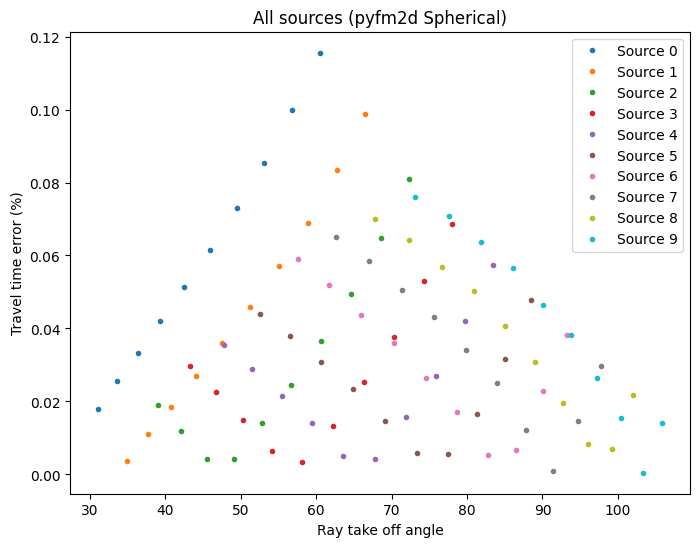

In [30]:
# plot travel time error for multiple rays
source = 3
source = 'all'
resultfmm = result_300_300_sph
lab = 'All sources (pyfm2d, Spherical 300x300)'
fig = plt.figure(figsize = (8,6))
cmap = plt.get_cmap("tab10")
if(source == 'all'):
    for i in range(len(srcs)):
        dt = 100*(np.abs(resultfmm.ttimes[i*nr:nr*(i+1)] - ttimes_anal[i*nr:nr*(i+1)]))/ttimes_anal[i*nr:nr*(i+1)]
        plt.plot(angles[i*nr:nr*(i+1)],dt,'.',color=cmap(i),label='Source '+str(i))
    plt.legend()
else:
    i = source
    dt = 100*(np.abs(resultfmm.ttimes[i*nr:nr*(i+1)] - ttimes_anal[i*nr:nr*(i+1)]))/ttimes_anal[i*nr:nr*(i+1)]
    plt.plot(angles[i*nr:nr*(i+1)],dt,'.',label='Source '+str(i))
    
if(source == 'all'): 
    plt.title('All sources (pyfm2d Spherical)')
else:
    plt.title('Rays for source '+str(source))    
plt.xlabel('Ray take off angle')
plt.ylabel('Travel time error (%)')
plt.show()

#### Repeat in Cartesian mode

In [31]:
# create 10 sources of left and 10 receiver on right
recs = pyfm2d.wavetracker.generate_surface_points(
    10, extent=[0,30.,0.,28.], surface=[False, True, False, False], addCorners=False
)  # generate receivers around edge
srcs = pyfm2d.wavetracker.generate_surface_points(
    10, extent=[0,30.,0.,28.], surface=[True, False, False, False], addCorners=False
)  # generate receivers around edge
nr = len(recs)  # number of receivers
ns = len(srcs)  # number of sources

Calculate analytical solutions.

In [32]:
thetas = circular_raypaths(srcs,recs,vo,vg) # Calculate circular raypaths between all sources and receivers
angles = [t*180/np.pi for t in thetas] # take off angles in degrees for all rays
ttimes_anal = tt_circular_paths_anal(srcs,recs,vo,vg) # analaytical travel times between all sources and receivers 

Calculate Fast Marching solutions using Cartesian mode.

In [33]:
options = pyfm2d.WaveTrackerOptions(
    times=True,
    frechet=True,
    paths=True,
    earthradius=6371.0,
    ttfield_source=0,  # select a source index to calculate and display wavefronts.
    cartesian = True,
)

In [34]:
extent=[0,30.,0.,30.]

In [35]:
velocity = velocity_300_300
result_300_300_cart = pyfm2d.calc_wavefronts(velocity, recs, srcs, extent=extent, options=options)
print(" Number of paths calculated = ", len(result_300_300_cart.paths))
print(" Number of travel times calculated = ", len(result_300_300_cart.ttimes))
print(" Shape of frechet matrix = ", result_300_300_cart.frechet.shape)

 Number of paths calculated =  100
 Number of travel times calculated =  100
 Shape of frechet matrix =  (100, 90000)


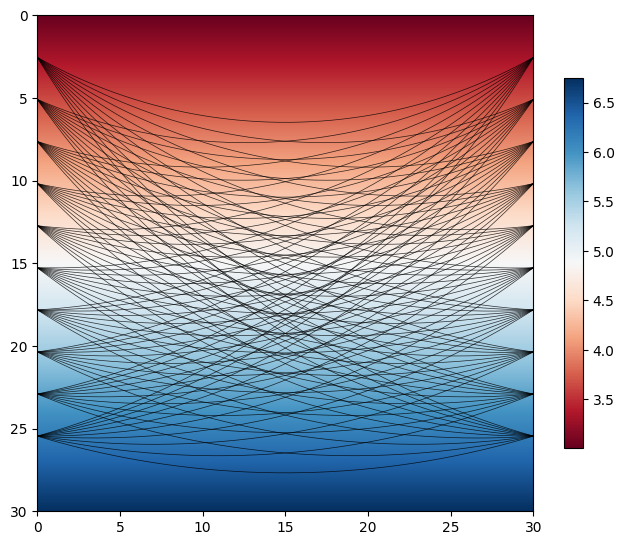

In [36]:
pyfm2d.display_model(velocity, extent=extent, figsize=(8, 8),     
              paths=result_300_300_cart.paths,
              alpha=0.8,
              line = 0.5,
              cline = 'k',
              reversedepth=True)

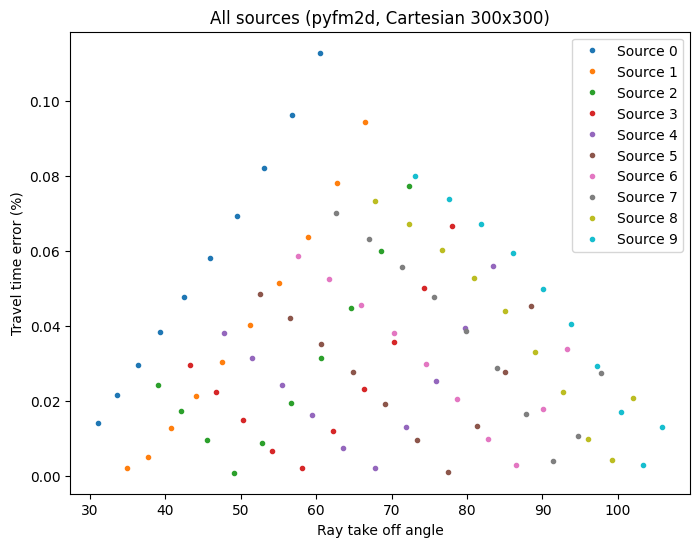

In [37]:
# plot travel time error for multiple rays
source = 3
source = 'all'
resultfmm = result_300_300_cart
lab = 'All sources (pyfm2d, Spherical 300x300)'
lab = 'All sources (pyfm2d, Cartesian 300x300)'
fig = plt.figure(figsize = (8,6))
cmap = plt.get_cmap("tab10")
if(source == 'all'):
    for i in range(len(srcs)):
        dt = 100*(np.abs(resultfmm.ttimes[i*nr:nr*(i+1)] - ttimes_anal[i*nr:nr*(i+1)]))/ttimes_anal[i*nr:nr*(i+1)]
        plt.plot(angles[i*nr:nr*(i+1)],dt,'.',color=cmap(i),label='Source '+str(i))
    plt.legend()
else:
    i = source
    dt = 100*(np.abs(resultfmm.ttimes[i*nr:nr*(i+1)] - ttimes_anal[i*nr:nr*(i+1)]))/ttimes_anal[i*nr:nr*(i+1)]
    plt.plot(angles[i*nr:nr*(i+1)],dt,'.',label='Source '+str(i))
    
if(source == 'all'): 
    plt.title(lab)
else:
    plt.title('Rays for source '+str(source))    
plt.xlabel('Ray take off angle')
plt.ylabel('Travel time error (%)')
plt.show()